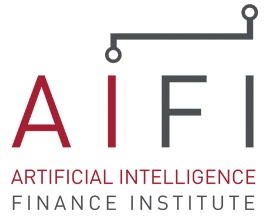


# Bootcamp - Supervised Machine Learning

## Testing data pipelines / data validation with Pandera

# About this Notebook

In this notebook, we will validate and test multiple columns of financial data using Pandera, a flexible and expressive data validation library for Python.

The first section of the notebook is dedicated to validating multiple columns. In this scenario, we are using Yahoo Finance to fetch data for the AAPL (Apple Inc.) stock. We create a `DataFrameSchema` from Pandera and define the schema for the data frame that we will receive. This schema enforces that each column in the data frame is of a certain type, and it runs checks to validate that each column's data satisfies certain conditions. For instance, we are checking that the 'Open', 'High', 'Low', 'Close', 'Adj Close' columns are of the type Float and that their values are greater than or equal to 0. We also define the schema for 'Volume' column to be of type integer and its value to be greater than or equal to 0. Finally, we validate the data using the defined schema.

In the second section, we apply a custom check using a lambda function to validate data across columns. Here, we're checking that the "High" column in each row is greater than or equal to the maximum of the "Open", "Close", and "Low" columns in the same row. This demonstrates the ability of Pandera to execute complex, cross-column comparisons.

The third section of the notebook demonstrates the concept of lazy validation, where we delay the execution of checks until calling the `validate()` method. This enables us to gather all the errors that may occur during the validation process, rather than throwing the first error encountered.

Next, we implement custom validators using lambda functions. These custom validators are used to check certain conditions in the 'Open', 'Close', and 'Volume' columns. For instance, we ensure that the mean opening price is less than 200, the closing price is above 0, and the volume is non-negative.

The last section of the notebook implements a machine learning workflow. We first fetch the data for the AAPL stock, preprocess it to create lag features, and then split it into training and testing sets. We train a Linear Regression model on the training set and make predictions on the testing set. After generating the predictions, we compute the residuals and perform a normality test on them. We then use Pandera to validate the residuals.

In summary, this notebook provides a comprehensive overview of data validation using Pandera, from simple column checks to cross-column checks and more complex, custom validation scenarios. It demonstrates how data validation is a crucial step in any data analysis or machine learning workflow, ensuring the integrity and reliability of the results.

### What is Pandera?

Pandera is a validation framework for `pandas` DataFrames during runtime to make data pipelines more readable and robust. Pandera's design philosophy is tied to pandas. 

Features at a glance:

1. Check the data types and data in columns of a DataFrame
2. Statistical validation like hypothesis testing
3. Non-invasive additions to codebase

# Imports

In [1]:
%%capture
!pip install pandera

In [ ]:
import yfinance as yf
import pandera as pa
import traceback
import pandas as pd
from pandera import Check
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import normaltest

## Validating a Single Column


We do single column validation using the `pandara.Column` class. This takes in a `pandas.Series` object and applies `checks` on them. Pandera has some built in checks attached to the `pa.Check` class. To give a clue what is available, we list some of them here:


| Check | Description |
| --- | ----------- |
| eq | Ensure all elements of a series equal a certain value. |
| equal_to | Ensure all elements of a series equal a certain value. |
| ge | Ensure all values are greater or equal a certain value. |
| in_range | Ensure all values of a series are within an interval. |
| isin | Ensure only allowed values occur within a series. |
| str_contains | Ensure that a pattern can be found within each row. |
| str_length | Ensure that the length of strings is within a specified range. |

For a full list. See the [Pandera Check API](https://pandera.readthedocs.io/en/stable/reference/generated/pandera.checks.Check.html#pandera-checks-check)

The following cell shows the syntax for Column validation.

In [27]:
# Fetch data
data = yf.download('AAPL', start='2020-01-01', end='2023-12-31')

# Define checks
open_check = pa.Column(float, checks=pa.Check.greater_than(0), name="Open")
close_check = pa.Column(float, checks=pa.Check.greater_than(0), name="Close")

# Validate individual columns - note that we convert Series to DataFrame
validated_open = open_check.validate(data[['Open']])
validated_close = close_check.validate(data[['Close']])

print(validated_open.head())
print(validated_close.head())


[*********************100%***********************]  1 of 1 completed
                 Open
Date                 
2020-01-02  74.059998
2020-01-03  74.287498
2020-01-06  73.447502
2020-01-07  74.959999
2020-01-08  74.290001
                Close
Date                 
2020-01-02  75.087502
2020-01-03  74.357498
2020-01-06  74.949997
2020-01-07  74.597504
2020-01-08  75.797501


In [26]:
data["Open"]

Date
2020-01-02     74.059998
2020-01-03     74.287498
2020-01-06     73.447502
2020-01-07     74.959999
2020-01-08     74.290001
                 ...    
2023-07-17    191.899994
2023-07-18    193.350006
2023-07-19    193.100006
2023-07-20    195.089996
2023-07-21    194.100006
Name: Open, Length: 894, dtype: float64

## Validating Multiple Columns

To group `pandera.Column` objects together, `pandera` offers the `pandera.DataFrameSchema`. With this, we can specify the whole validation schema, and then use the `validate()` method too call everything at once. 

Otherwise, we would have to use the `pandera.Column` syntax and the `validate()` method. But in reality, this means we would need to call `validate()` for each of our `pandera.Column` objects. That would be a lot of boilerplate code. 

In the example below, we use a validator:


In [2]:
# Fetch data
data = yf.download('AAPL', start='2020-01-01', end='2022-12-31')

# Define schema
schema = pa.DataFrameSchema(
    {
        "Open": pa.Column(pa.Float, checks=pa.Check.greater_than_or_equal_to(0)),
        "High": pa.Column(pa.Float, checks=pa.Check.greater_than_or_equal_to(0)),
        "Low": pa.Column(pa.Float, checks=pa.Check.greater_than_or_equal_to(0)),
        "Close": pa.Column(pa.Float, checks=pa.Check.greater_than_or_equal_to(0)),
        "Adj Close": pa.Column(pa.Float, checks=pa.Check.greater_than_or_equal_to(0)),
        "Volume": pa.Column(pa.Int, checks=pa.Check.greater_than_or_equal_to(0)),
    },
    index=pa.Index(pa.DateTime),
)

# Validate data
try:
    validated_data = schema(data)
    print("Schema validation successful.")
except Exception as e:
    traceback.print_exc()


[*********************100%***********************]  1 of 1 completed


In [3]:
# Validate data
validated_data = schema(data)

## Validation Across Columns

So far, all the validation we have done was through the `pandera.Column` object. What happens when we need to compare values across columns? This requires a DataFrame-wide check.
                     
In `pandera` this can be done with a custom check using a lambda. The syntax for this is below.

In [21]:
# Fetch data
data = yf.download('AAPL', start='2020-01-01', end='2022-12-31')

# Define schema
schema = pa.DataFrameSchema(
    {
        "Open": pa.Column(pa.Float, checks=pa.Check.greater_than_or_equal_to(0)),
        "High": pa.Column(pa.Float, checks=[
            pa.Check.greater_than_or_equal_to(0),
            pa.Check(lambda s: s >= data.loc[s.index, ["Open", "Close", "Low"]].max(axis=1))]),
        "Low": pa.Column(pa.Float, checks=pa.Check.greater_than_or_equal_to(0)),
        "Close": pa.Column(pa.Float, checks=pa.Check.greater_than_or_equal_to(0)),
        "Adj Close": pa.Column(pa.Float, checks=pa.Check.greater_than_or_equal_to(0)),
        "Volume": pa.Column(pa.Int, checks=pa.Check.greater_than_or_equal_to(0)),
    },
    index=pa.Index(pa.DateTime),
)

# Validate data
try:
    validated_data = schema.validate(data)
    print("Schema validation successful.")
except Exception as e:
    traceback.print_exc()


[*********************100%***********************]  1 of 1 completed


In this code, we're checking that the "High" column in each row is greater than or equal to the maximum of the "Open", "Close", and "Low" columns in the same row. This is performed by the lambda function inside the pa.Check() call. Please note that when we are doing these cross-column comparisons, we're essentially running a check on each individual row, rather than on the entire DataFrame.

### Lazy Validation

The `validate()` method takes in a `lazy` keyword. This can be used to run all of the validations before raising an error that we can get all of failed validations and the values that caused them.

We can extract the failure cases from the error with `err.failure_cases`. `err_data` gives us the original DataFrame that was validated on.


- The code block first uses the `yfinance` library to download historical stock price data for two companies - Apple (AAPL) and Microsoft (MSFT) - for the specified date range (from January 1, 2020, to December 31, 2023).

- Next, the data for the two companies is concatenated into one DataFrame using `pd.concat()`. The `keys` argument is used to distinguish the rows that belong to each company. The `reset_index()` and `rename()` functions are used to transform the multi-indexed DataFrame into a single-indexed DataFrame where the company ticker (AAPL or MSFT) is a column rather than an index.

- Then, a `DataFrameSchema` is created using the `pandera` library. This schema specifies the expected data types of each column in the DataFrame (string for the company ticker, datetime for the date, float for the open, high, low, close and adjusted close prices, and integer for the volume).

- Finally, the code block uses a `try/except` block to validate the data against the schema in a "lazy" mode, meaning that it collects all errors before raising an exception rather than stopping at the first error. If the data pass the validation, a success message is printed. If any errors are found, they are printed along with the portion of the DataFrame that failed validation. This helps to identify and fix any issues with the data.

In [28]:
# Download stock price data
data_aapl = yf.download('AAPL', start='2020-01-01', end='2023-12-31')
data_msft = yf.download('MSFT', start='2020-01-01', end='2023-12-31')

# Concatenate the data
data = pd.concat([data_aapl, data_msft], keys=['AAPL', 'MSFT']).reset_index().rename(columns={'level_0': 'ticker'})

# Lazy Validation
schema = pa.DataFrameSchema({
    "ticker": pa.Column(str),
    "Date": pa.Column(pa.DateTime),
    "Open": pa.Column(float),
    "High": pa.Column(float),
    "Low": pa.Column(float),
    "Close": pa.Column(float),
    "Adj Close": pa.Column(float),
    "Volume": pa.Column(int)
})

try:
    schema.validate(data, lazy=True)
    print("Schema validation successful.")
except pa.errors.SchemaErrors as err:
    print("Schema errors and failure cases:")
    print(err.failure_cases)
    print("\nDataFrame object that failed validation:")
    print(err.data)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Schema validation successful.


## Custom Validator

We created a custom `pandera.Check` object with a lambda earlier for the DataFrame-wide check. But the `pandera.Check` is not limited to DataFrame-wide checks. In fact, it does have an interesting behavior in that it can operate different based on the input function and `element_wise` flag.

Here we show the three different behaviors:

1. Column aggregate. Returns a single bool
2. Vectorized check. Returns a boolean Series
3. Element-wise check. Returns a bool for each element

In [29]:
# Custom Validator
schema = pa.DataFrameSchema({
    # a vectorized check that returns a bool, checks if the mean opening price is less than 200
    "Open": pa.Column(float, pa.Check(lambda s: s.mean() < 200, element_wise=False)),
    # a vectorized check that returns a boolean Series, checks if closing price is above 0
    "Close": pa.Column(float, pa.Check(lambda s: s > 0, element_wise=False)),
    # an element-wise check that returns a bool, checks if volume is non-negative
    "Volume": pa.Column(int, pa.Check(lambda x: x >= 0, element_wise=True)),
})


try:
    schema.validate(data, lazy=True)
    print("Schema validation successful.")
except pa.errors.SchemaErrors as err:
    print(err.failure_cases)


Schema validation successful.


__Brief code explanation__:

- A custom DataFrameSchema is defined using the pandera library. This schema validates specific conditions on certain columns.

- For the "Open" column, which represents the opening price, the lambda function checks whether the mean opening price is less than 200. element_wise=False means that the check function is applied to the whole series.

- For the "Close" column, which represents the closing price, the lambda function checks if all closing prices are above 0. Here, element_wise=False means that the check function is applied to the whole series. If all elements in the series meet the condition, it returns True.

- For the "Volume" column, the lambda function checks if the volume is non-negative (greater than or equal to zero). The element_wise=True argument means that the check function is applied to each individual element in the series.

- The try/except block is used to validate the DataFrame. If the DataFrame passes all the checks, a success message is printed. If any errors are found, the except block catches the exception and prints out the details of all failures. lazy=True is passed to schema.validate() so that all checks are run before any errors are raised, allowing you to see all the issues at once.

Please note that this is just an illustrative example. The specific checks and conditions you would apply in practice would depend on the nature and requirements of your data analysis task.

## Hypothesis Testing

One of the strengths of Pandera is the support for statistical tests using the `pandera.Hypothesis` interface that can use tests from the `scipy` library. For example, the following code is taken from the `pandera` docs as a way to test for normality.

### Raise Warning

As a side note, if a `pandera.Check` or `pandera.Hypothesis` is not core to your use case, you can use the `raise_warning` flag to raise a `UserWarning` instead of a `SchemaError`. This will not interrupt the program from running.

In [17]:
# Fetch data
data = yf.download('AAPL', start='2020-01-01', end='2023-12-31')

# Preprocess data: Use the previous day's opening, high, low, closing prices and volume as features to predict the next day's closing price
data['Open_lag1'] = data['Open'].shift(1)
data['High_lag1'] = data['High'].shift(1)
data['Low_lag1'] = data['Low'].shift(1)
data['Close_lag1'] = data['Close'].shift(1)
data['Volume_lag1'] = data['Volume'].shift(1)
data.dropna(inplace=True)

features = ['Open_lag1', 'High_lag1', 'Low_lag1', 'Close_lag1', 'Volume_lag1']
target = 'Close'

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# Train a Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions on the testing set
predictions = lr.predict(X_test)

# Compute residuals
residuals = y_test - predictions

# Perform a normality test on the residuals
stat, p = normaltest(residuals)


[*********************100%***********************]  1 of 1 completed


In [ ]:
def check_normality(p_value):
    alpha = 1e-3
    if p_value < alpha:  # null hypothesis: x comes from a normal distribution
        return False
    return True

df_residuals = pd.DataFrame({'residuals': residuals})

schema = pa.DataFrameSchema({
    'residuals': pa.Column(pa.Float, [
        Check(lambda s: len(s) >= 8, element_wise=False),
        Check(lambda s: check_normality(normaltest(s.dropna())[1]), element_wise=False)
    ])
})


In [18]:
try:
    validated_df = schema.validate(df_residuals)
    print("Schema validation successful.")
except pa.errors.SchemaError as e:
    print("Data validation failed:", e)
except Exception as e:
    print("An unexpected error occurred during validation:", e)


__Short explanation for the above code:__

- First, historical data is downloaded for the Apple Inc. (AAPL) stock from Yahoo Finance, from January 1, 2020 to December 31, 2023.

- The code then prepares the data for use in a machine learning model by adding lagged features to the data. The `shift()` function is used to shift the 'Open', 'High', 'Low', 'Close', and 'Volume' columns back by one day. This creates new features that represent the previous day's values for these columns. Any rows with missing values (NaN) resulting from the shifting process are dropped.

- The 'Open_lag1', 'High_lag1', 'Low_lag1', 'Close_lag1', and 'Volume_lag1' columns are designated as features (`X`), and the 'Close' column is designated as the target (`y`). The data is then split into training and testing sets, with 20% of the data reserved for testing.

- A Linear Regression model is trained on the training data.

- The trained model is used to make predictions on the testing set, and residuals (the differences between the observed and predicted closing prices) are computed.

- A normality test (`normaltest()`) is performed on the residuals to check if they are normally distributed. The function check_normality() compares the p-value from the normality test against a threshold (alpha). If the p-value is less than alpha, the null hypothesis that the residuals come from a normal distribution is rejected, and `False` is returned; otherwise, `True` is returned.

- A DataFrame containing the residuals is created, and a pandera schema is defined to validate it. The schema includes two checks: one to ensure there are at least 8 samples (as required for the skewness test in `normaltest()`), and the other to verify the normality of the residuals using the `check_normality()` function.


The last part of the code attempts to validate the DataFrame containing the residuals (`df_residuals`) against the schema defined in the previous part. If the data validation is successful, it prints "Schema validation successful."

However, if a `SchemaError` is encountered during validation (for example, if the residuals do not pass the checks defined in the schema), it will catch this exception and print "Data validation failed" along with information about the error.

In addition to this, it also includes a more general exception handler for other types of errors that may occur during validation. If such an exception is encountered, it will catch this exception and print "An unexpected error occurred during validation" along with the details about the error.

This type of error handling in the code is very beneficial because it can help to identify and troubleshoot issues more easily and makes the code more robust to potential errors or edge cases.

__This code represents a complete data analysis workflow, from data preparation and machine learning model training, to making predictions and validating the results using statistical tests and schema validation.__